# Debiasing italian word embeddings

### Downlaod data 
First of all, you need to download the Italian Twitter Embeddings pretraned from the following link [here](https://drive.google.com/file/d/1eq2Ehc8Tpj_9oFPVSFdZ1aN9YJm7J55s/view?usp=sharing) and insert the file into the `embeddings` folder.

In [65]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import json

import debiaswe.we as we
from debiaswe.we import WordEmbedding
from gensim.models import KeyedVectors

import tqdm

## 1. Analysis of the embeddings

In [142]:
# load the word embeddings
embeddings = WordEmbedding('./embeddings/filtered_itwac128.tsv')

*** Reading data from ./embeddings/filtered_itwac128.tsv
(537325, 128)
537325 words of dimension 128 : di, e, che, la, ..., checcosf, dacris, pawprint, eorismo


### 1.1 Define gender direction

We define gender direction by the pricipal component of 6 directions extracted from specific gender pairs like `"lei"-"lui"`, `"donna"-"uomo"`, etc., that largely captures gender in the embedding. This direction helps us to quantify direct and indirect biases in words and associations.

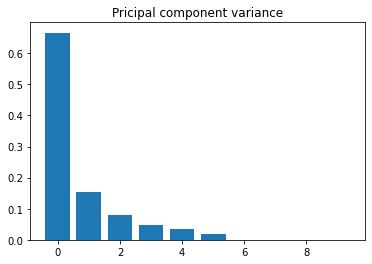

In [143]:
# compute gender direction
female_definitional = ["lei", "donna", "madre", "moglie", "sorella", "femmina"]
male_definitional = ["lui", "uomo", "padre", "marito", "fratello", "maschio"]
gender_definitional_pairs = list(zip(male_definitional, female_definitional))

gender_direction = we.doPCA(gender_definitional_pairs, embeddings).components_[0]

# plot variance
plt.bar(range(10), we.doPCA(gender_definitional_pairs, embeddings).explained_variance_ratio_)
plt.title("Pricipal component variance")
plt.show()

### 1.2 Exploit relations between words computing analogies

In [144]:
# convert WordEmbedding into word2vec format
tmp_file='./embeddings/filtered_itwac_w2v.bin'
embeddings.save_w2v(tmp_file)
w2v_embeddings = KeyedVectors.load_word2vec_format(tmp_file, binary=True)

### Uomo : comanda = donna : obbedisce

In [149]:
w2v_embeddings.most_similar(positive=['donna', 'informatica'], negative=['uomo'], topn=10)

[('comunicaizone', 0.5892785787582397),
 ('programmatrice', 0.5631255507469177),
 ('multimedialità', 0.5538277626037598),
 ('consulenza', 0.5276974439620972),
 ('sistemistica', 0.5047318935394287),
 ('telemedicina', 0.4999392330646515),
 ('studentessa', 0.49901556968688965),
 ('videocomunicazione', 0.49582791328430176),
 ('radiofonia', 0.49478504061698914),
 ('specializzazione', 0.49374085664749146)]

## 2. Degree classes stereotypes

### 2.1 Gender bias correlation in degree classes

In [150]:
# read the dataset about the gender distrubution in italian degree classes
data = pd.read_csv("./data/degree_classes.csv", delimiter=";", encoding='latin-1')
data = data[data['AnnoA'] == '2020/2021']
data = data.pivot_table(columns=['SESSO'], index=['ClasseNOME'], values ='Isc', fill_value=0, aggfunc=sum)
data = pd.DataFrame(np.hstack([np.array(data.index).reshape(-1, 1), data.values]), columns=['ClasseNOME', 'F', 'M'])

In [151]:
# read the aliases of the degree classes
degree_classes_aliases = json.load(open("./data/degree_classes_aliases.json", "r"))

In [152]:
# keep only interesing classes
gender_degree_classes = data[data['ClasseNOME'].isin(degree_classes_aliases.keys())]
gender_degree_classes['ClasseNOME'] = gender_degree_classes['ClasseNOME'].map(degree_classes_aliases)

# change the count to percentage
total = gender_degree_classes['F']+gender_degree_classes['M']
gender_degree_classes['F'] = gender_degree_classes['F']/(total)
gender_degree_classes['M'] = gender_degree_classes['M']/(total)
gender_degree_classes.sort_values(by='F')

C:\Users\peppe\AppData\Local\Temp\ipykernel_20616\1266523254.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gender_degree_classes['ClasseNOME'] = gender_degree_classes['ClasseNOME'].map(degree_classes_aliases)
C:\Users\peppe\AppData\Local\Temp\ipykernel_20616\1266523254.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gender_degree_classes['F'] = gender_degree_classes['F']/(total)
C:\Users\peppe\AppData\Local\Temp\ipykernel_20616\1266523254.py:8: SettingWithCopyWarning: 
A value is trying to be set 

,ClasseNOME,F,M
43,ingegneria,0.157637,0.842363
34,automazione,0.161376,0.838624
26,informatica,0.162022,0.837978
39,elettronica,0.16318,0.83682
28,aerospaziale,0.182731,0.817269
24,fisica,0.271238,0.728762
114,agraria,0.28292,0.71708
23,finanza,0.316045,0.683955
264,urbanistica,0.351351,0.648649
125,geologia,0.370248,0.629752


In [ ]:
"""def analogy(positive1, negative1, positive2, embedding, topn=10):
    relationship_1 = embedding.diff(positive1, negative1)
    relationship_2 = np.array([embedding.diff(positive2, word) for word in embedding.words])

    # compute cosine similarity
    dots = relationship_2.dot(relationship_1)

    thresh = sorted(dots)[-topn]
    return sorted([(w, dot) for w, dot in zip(embedding.words, dots) if dot>=thresh], key=lambda x: x[1], reverse=True)

print("Most similar:") 
analogy(positive1="uomo", negative1="calcio", positive2="donna", embedding=E, topn=10)"""

In [153]:
sp = sorted([(embeddings.v(w).dot(gender_direction), w) for w in degree_classes_aliases.values()])
sp

[(-0.10190201, 'agraria'),
 (-0.058879457, 'infermieristica'),
 (-0.04706604, 'elettronica'),
 (-0.03023807, 'aerospaziale'),
 (-0.029271245, 'urbanistica'),
 (-0.025648333, 'informatica'),
 (-0.02378138, 'biotecnologie'),
 (0.0023004822, 'antropologia'),
 (0.0046792235, 'automazione'),
 (0.014736714, 'sociologia'),
 (0.01811924, 'ingegneria'),
 (0.018392682, 'odontoiatria'),
 (0.025583692, 'economia'),
 (0.02846541, 'zootecnica'),
 (0.028731793, 'archeologia'),
 (0.038101304, 'fisica'),
 (0.04940738, 'lettere'),
 (0.050898246, 'biomedica'),
 (0.05916567, 'statistica'),
 (0.06062073, 'geologia'),
 (0.08065692, 'veterinaria'),
 (0.088318035, 'matematica'),
 (0.093329236, 'lingue'),
 (0.09942613, 'musicologia'),
 (0.09959995, 'chimica'),
 (0.102872215, 'architettura'),
 (0.11491446, 'chirurgia'),
 (0.11745678, 'finanza'),
 (0.13365737, 'biologia'),
 (0.13491368, 'psicologia'),
 (0.14080364, 'pedagogia'),
 (0.14219052, 'filosofia'),
 (0.16015431, 'comunicazione'),
 (0.17377949, 'giurispru

In [154]:
dict_ = {b:a for a, b in sp}
dict_

{'agraria': -0.10190201,
 'infermieristica': -0.058879457,
 'elettronica': -0.04706604,
 'aerospaziale': -0.03023807,
 'urbanistica': -0.029271245,
 'informatica': -0.025648333,
 'biotecnologie': -0.02378138,
 'antropologia': 0.0023004822,
 'automazione': 0.0046792235,
 'sociologia': 0.014736714,
 'ingegneria': 0.01811924,
 'odontoiatria': 0.018392682,
 'economia': 0.025583692,
 'zootecnica': 0.02846541,
 'archeologia': 0.028731793,
 'fisica': 0.038101304,
 'lettere': 0.04940738,
 'biomedica': 0.050898246,
 'statistica': 0.05916567,
 'geologia': 0.06062073,
 'veterinaria': 0.08065692,
 'matematica': 0.088318035,
 'lingue': 0.093329236,
 'musicologia': 0.09942613,
 'chimica': 0.09959995,
 'architettura': 0.102872215,
 'chirurgia': 0.11491446,
 'finanza': 0.11745678,
 'biologia': 0.13365737,
 'psicologia': 0.13491368,
 'pedagogia': 0.14080364,
 'filosofia': 0.14219052,
 'comunicazione': 0.16015431,
 'giurisprudenza': 0.17377949,
 'geografia': 0.18290636,
 'farmacia': 0.24890259,
 'letter

In [155]:
pairs = np.array([[dict_[row['ClasseNOME']], row['M']] for i, row in gender_degree_classes.iterrows()])
pairs

array([[ 0.00230048,  0.29591249],
       [ 0.02873179,  0.34079309],
       [ 0.10287222,  0.41353479],
       [ 0.13365737,  0.27556441],
       [-0.02378138,  0.32303577],
       [ 0.24890259,  0.25993122],
       [ 0.25004864,  0.31327913],
       [ 0.14219052,  0.50210339],
       [ 0.11745678,  0.68395462],
       [ 0.0381013 ,  0.72876199],
       [ 0.18290636,  0.51973684],
       [-0.02564833,  0.83797837],
       [-0.03023807,  0.8172686 ],
       [ 0.05089825,  0.40070988],
       [ 0.00467922,  0.83862434],
       [-0.04706604,  0.83682008],
       [ 0.01811924,  0.84236305],
       [ 0.04940738,  0.27486241],
       [ 0.09332924,  0.19504862],
       [ 0.17377949,  0.36417354],
       [ 0.08831804,  0.50206856],
       [ 0.11491446,  0.42574184],
       [ 0.08065692,  0.27745894],
       [ 0.09942613,  0.39856115],
       [ 0.01839268,  0.49261935],
       [-0.05887946,  0.24306394],
       [ 0.13491368,  0.19193148],
       [ 0.02558369,  0.55330968],
       [ 0.16015431,

In [156]:
gender_score, female_perc = pairs[:,0], pairs[:,1]

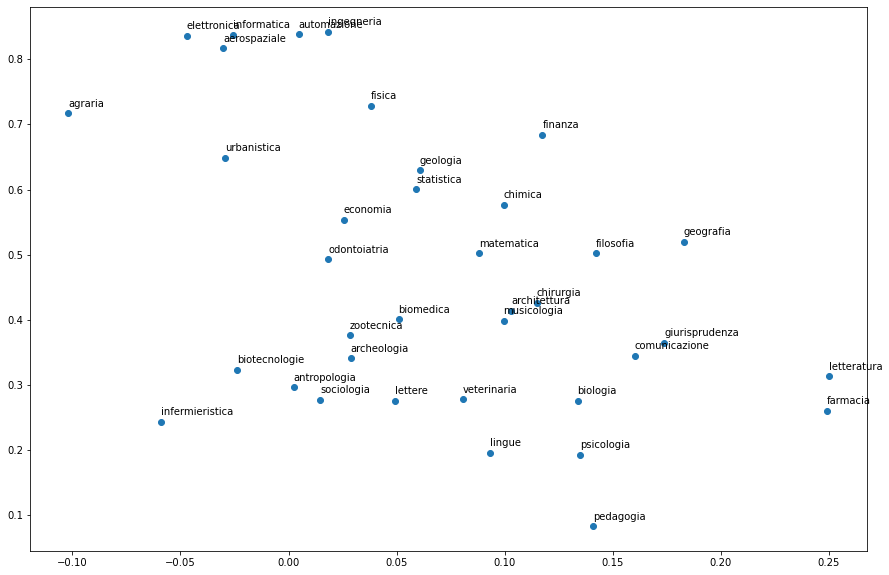

In [157]:
plt.figure(figsize=(15,10))
plt.scatter(gender_score, female_perc)
for i in range(len(gender_degree_classes)):
    plt.annotate(gender_degree_classes['ClasseNOME'].tolist()[i], (gender_score[i], female_perc[i] + 0.01))

In [158]:
import scipy
scipy.stats.spearmanr(gender_score, female_perc)

SpearmanrResult(correlation=-0.3897581792318634, pvalue=0.017097874665928183)

In [159]:
scipy.stats.pearsonr(gender_score, female_perc)

(-0.46105783408372125, 0.00407908700197112)

## 3. Debias

In [160]:
from debiaswe.debias import debias

In [161]:
# Lets load some gender related word lists to help us with debiasing

with open('./data/equalize_pairs_it.json', "r") as f:
    equalize_pairs = json.load(f)

In [162]:
debias(embeddings, degree_classes_aliases, gender_definitional_pairs, equalize_pairs)

537325 words of dimension 128 : di, e, che, la, ..., checcosf, dacris, pawprint, eorismo
{('BENZINAIO', 'BENZINAIA'), ('ORAFO', 'ORAFA'), ('VETRAIO', 'VETRAIA'), ('montatore', 'montatrice'), ('Viticoltore', 'Viticoltrice'), ('manutentore', 'manutentrice'), ('AMMINISTRATORE', 'AMMINISTRATRICE'), ('AGRONOMO', 'AGRONOMA'), ('spazzino', 'spazzina'), ('Vigilatore', 'Vigilatrice'), ('Rematore', 'Rematrice'), ('parcheggiatore', 'parcheggiatrice'), ('ballerino', 'ballerina'), ('Marinaio', 'Marinaia'), ('Pellicciaio', 'Pellicciaia'), ('BIBLIOTECARIO', 'BIBLIOTECARIA'), ('OTTICO', 'OTTICA'), ('BOTANICO', 'BOTANICA'), ('BIOLOGO', 'BIOLOGA'), ('Poliziotto', 'Poliziotta'), ('', 'portantina'), ('Scultore', 'Scultrice'), ('poliziotto', 'poliziotta'), ('Montatore', 'Montatrice'), ('POLIZIOTTO', 'POLIZIOTTA'), ('GELATAIO', 'GELATAIA'), ('Allenatore', 'Allenatrice'), ('CLIMATOLOGO', 'CLIMATOLOGA'), ('operaio', 'operaia'), ('ALLENATORE', 'ALLENATRICE'), ('OROLOGIAIO', 'OROLOGIAIA'), ('medico', 'medica'),

In [163]:
sp = sorted([(embeddings.v(w).dot(gender_direction), w) for w in degree_classes_aliases.values()])
sp

[(-0.44250977, 'veterinaria'),
 (-3.7252903e-08, 'psicologia'),
 (-3.3527613e-08, 'geografia'),
 (-2.9802322e-08, 'letteratura'),
 (-2.6077032e-08, 'lingue'),
 (-1.8626451e-08, 'farmacia'),
 (-1.8626451e-08, 'sociologia'),
 (-1.6763806e-08, 'pedagogia'),
 (-1.4901161e-08, 'antropologia'),
 (-1.4901161e-08, 'finanza'),
 (-1.4901161e-08, 'zootecnica'),
 (-1.3038516e-08, 'informatica'),
 (-1.1175871e-08, 'statistica'),
 (-9.313226e-09, 'lettere'),
 (-7.450581e-09, 'infermieristica'),
 (-5.5879354e-09, 'biomedica'),
 (-3.7252903e-09, 'filosofia'),
 (-3.7252903e-09, 'ingegneria'),
 (0.0, 'aerospaziale'),
 (0.0, 'economia'),
 (0.0, 'fisica'),
 (0.0, 'odontoiatria'),
 (1.8626451e-09, 'chimica'),
 (1.8626451e-09, 'musicologia'),
 (3.7252903e-09, 'archeologia'),
 (3.7252903e-09, 'biotecnologie'),
 (7.450581e-09, 'architettura'),
 (7.450581e-09, 'elettronica'),
 (7.450581e-09, 'urbanistica'),
 (9.313226e-09, 'automazione'),
 (1.0244548e-08, 'matematica'),
 (1.4901161e-08, 'agraria'),
 (1.4901161

In [164]:
# convert WordEmbedding into word2vec format
tmp_file='./embeddings/twitter_w2v_debiased.bin'
embeddings.save_w2v(tmp_file)
w2v_embeddings = KeyedVectors.load_word2vec_format(tmp_file, binary=True)

In [168]:
w2v_embeddings.most_similar(positive=['donna', 'programmatore'], negative=['uomo'], topn=10)

[('disegnatrice', 0.6150364875793457),
 ('sistemista', 0.6139325499534607),
 ('ragioniera', 0.6125180721282959),
 ('sarta', 0.5797533988952637),
 ('puericultore', 0.5668995380401611),
 ('massaggiatrice', 0.5584173202514648),
 ('psicologa', 0.5571607351303101),
 ('formatrice', 0.5563755035400391),
 ('programmatrice', 0.5515722036361694),
 ('calciatrice', 0.5325778722763062)]